# Building an optimization problem for custom applications.

In this advanced notebook, we show that the JAX planner can be used to export the compiled planning problem to a pure Python function for other applications such as plotting or optimization with scipy.

Start by installing the required packages:

In [1]:
%pip install --quiet --upgrade pip
%pip install --quiet scipy
%pip install --quiet git+https://github.com/pyrddlgym-project/pyRDDLGym.git
%pip install --quiet git+https://github.com/pyrddlgym-project/rddlrepository.git
%pip install --quiet git+https://github.com/pyrddlgym-project/pyRDDLGym-jax.git

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Import the required packages:

In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

import pyRDDLGym
from pyRDDLGym_jax.core.planner import JaxStraightLinePlan, JaxBackpropPlanner, JaxOfflineController, load_config_from_string

We will load the CartPole example to illustrate the process:

In [3]:
env = pyRDDLGym.make('CartPole_Continuous_gym', '0', vectorized=True)

Next, we build the planner instance as usual, but we do not need the controller in this instance:

In [4]:
config = """
[Model]
logic_kwargs={'weight': 1000.0}
[Optimizer]
method='JaxStraightLinePlan'
optimizer_kwargs={'learning_rate': 0.001}
batch_size_train=1
batch_size_test=1
[Training]
"""
planner_args, train_args, _ = load_config_from_string(config)
planner = JaxBackpropPlanner(env.model, **planner_args)

Next, we will call the ``as_optimization_problem`` function, which will produce a loss function, a gradient function, an initial parameter vector, and a mapping to send parameter vectors back to JAX pytrees:

In [5]:
func, grad, init_param, np_to_dict = planner.as_optimization_problem()

To illustrate, the initial value vector is the vector of initial parameters of the policy. In this case:

In [6]:
init_param.shape

(200,)

Similarly, the function takes a parameter vector of size 800 as input, and produces the loss function value, equal to the negative of the cumulative return for that plan. The gradient function similarly computes the gradient vector of the plan's parameters at any given point:

In [7]:
print(func(init_param))
print(grad(init_param).shape)

-18.80849838256836
(200,)


The mapping provided as the fourth argument allows to map the vector of parameters back to a dictionary:

In [8]:
np_to_dict(init_param).keys()

dict_keys(['force'])

Because the return objective and its gradient are available as ordinary Python functions, we can do a lot of cool things now. For example, we can plot a low-dimensional loss surface around the initial parameter vector:

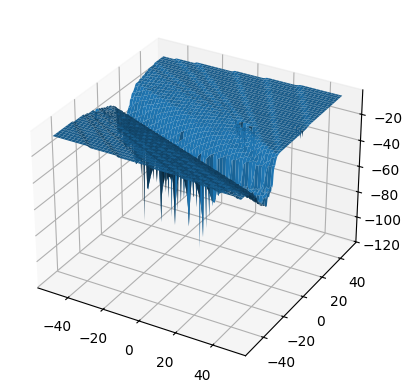

In [9]:
# generate two random directions along which to trace the loss surface
ray1 = np.random.uniform(-1, 1, size=init_param.shape)
ray2 = np.random.uniform(-1, 1, size=init_param.shape)

# sweep out all points spanned in subspace by these two directions - our plot will lie inside this subspace
%matplotlib inline
npts = 200
x = np.linspace(-50, 50, npts)
y = np.linspace(-50, 50, npts)
x, y = np.meshgrid(x, y)
z = [func(ray1 * xi + ray2 * yi) for xi, yi in zip(x.ravel(), y.ravel())]
z = np.reshape(z, x.shape)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(x, y, z)
plt.show()

Let's minimize this function using the scipy package:

In [10]:
opt = minimize(func, jac=grad, x0=init_param, options={'disp': True})
params = np_to_dict(opt.x)

Optimization terminated successfully.
         Current function value: -200.000000
         Iterations: 3
         Function evaluations: 24
         Gradient evaluations: 24


Finally, let's evaluate this agent to make sure the optimizer succeeded:

In [11]:
agent = JaxOfflineController(planner, params=params, **train_args)
agent.evaluate(env, episodes=1)

{'mean': np.float64(200.0),
 'median': np.float64(200.0),
 'min': np.float64(200.0),
 'max': np.float64(200.0),
 'std': np.float64(0.0)}